#Mean Shift RNN Block

## Imports

In [0]:
import torch
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision.transforms as tvtrans

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x590ac000 @  0x7f84fd5402a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
!git clone 'https://github.com/cocodataset/cocoapi.git'

fatal: destination path 'cocoapi' already exists and is not an empty directory.
ls: cannot access 'drive': Transport endpoint is not connected


In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

In [0]:
folder = '/content/gdrive/My Drive/mean shift data/'
files = os.listdir(folder)

im = []

for i, file in enumerate(files):
  os.rename(folder + file, folder + str(i))
  im.append(Image.open(folder + str(i)).resize((224, 224)))
  
for i in range(len(im)):
  im[i] = tvtrans.ToTensor()(im[i]).unsqueeze(0)

In [0]:
print(im[0].size())

torch.Size([1, 3, 224, 224])


In [0]:
backbone = models.resnet101(pretrained=True)
Y = backbone(im[0])
Y.size()

torch.Size([1, 1000])

## Single Block

In [0]:
def mean_shift_once(X, delta, eta=1):
  
  K = torch.exp(delta * torch.mm(X.t(), X))
  
  N = list(X.size())[1]
  ones = torch.ones(N, 1)
  D = torch.diagflat(torch.mm(K.t(), ones))
  D_inv = D.inverse()
  
  eye = torch.eye(N)
  
  shift = (eta * torch.mm(K, D_inv)) + ((1 - eta) * eye)
  X = torch.mm(X, shift)
  
  return X
  

### Test

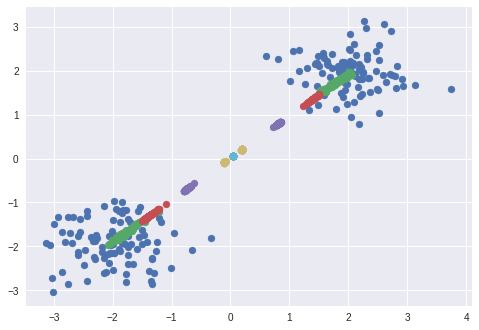

In [0]:
X_1 = -2 + 0.5 * torch.randn((2, 100))
X_2 = 2 + 0.5 * torch.randn((2, 100))
X = torch.cat((X_1, X_2), 1)

delta = torch.tensor([0.5/3])

# X = Y.detach().reshape(Y.shape[1], Y.shape[2])

for i in range(6):
  plt.scatter(X.numpy()[0], X.numpy()[1])
  X = mean_shift_once(X, delta)
 
plt.show()